In [1]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/compute/c

In [3]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [5]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [6]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_Pfizer.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [7]:
df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|text                                                                                                            |
+----------------------------------------------------------------------------------------------------------------+
|text                                                                                                            |
|Pfizer is looking  sign up people for a covid vaccine study You get a drug or a placebo Then OVER THE NEXT 2 YE |
|Pfizers COVID vaccine shows robust results in early trial                                                       |
|pfizers¬†covidvaccine                                                                                           |
|For more information   "                                                                                        |
|CovidVaccine COVID19 Some good news                                            

In [8]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [9]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [10]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|                text|                text|
|Pfizer is looking...|Pfizer is looking...|
|Pfizers COVID vac...|Pfizers COVID vac...|
|pfizers¬†covidvac...|pfizers¬†covidvac...|
|For more informat...|For more informat...|
|CovidVaccine COVI...|CovidVaccine COVI...|
|One of  vaccines ...|One of  vaccines ...|
|NVAX beats BNTX P...|NVAX beats BNTX P...|
|Though Pfizer use...|Though Pfizer use...|
|Phase III data on...|Phase III data on...|
|PfizerBioNTech CO...|PfizerBioNTech CO...|
|So psyched  be pa...|So psyched  be pa...|
|BioNTech cofounde...|BioNTech cofounde...|
|Read  Aug 21 News...|Read  Aug 21 News...|
|Read Carole Sians...|Read Carole Sians...|
|PfizerBioNTech sa...|PfizerBioNTech sa...|
|COVID19 Vaccines ...|COVID19 Vaccines ...|
|Pfizer  BioNTechs...|Pfizer  BioNTechs...|
|Pfizer Vaccine on...|Pfizer Vaccine on...|
|BioNTech CEO Ugar...|BioNTech C

In [11]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

6216

In [12]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [14]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|
|Pfizer is looking...|Pfizer is looking...|[pfizer, is, look...|[pfizer, looking,...|
|Pfizers COVID vac...|Pfizers COVID vac...|[pfizers, covid, ...|[pfizers, covid, ...|
|pfizers¬†covidvac...|pfizers¬†covidvac...|[pfizers¬†covidva...|[pfizers¬†covidva...|
|For more informat...|For more informat...|[for, more, infor...|       [information]|
|CovidVaccine COVI...|CovidVaccine COVI...|[covidvaccine, co...|[covidvaccine, co...|
|One of  vaccines ...|One of  vaccines ...|[one, of, , vacci...|[one, , vaccines,...|
|NVAX beats BNTX P...|NVAX beats BNTX P...|[nvax, beats, bnt...|[nvax, beats, bnt...|
|Though Pfizer use...|Though Pfizer use...|[though, pf

In [52]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [53]:
model.getVectors().show(truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [54]:
vecs = model.getVectors()

In [55]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [57]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('dose', 0.8528693914413452),
 ('jab', 0.8224495649337769),
 ('round', 0.7267473936080933),
 ('dad', 0.6712166666984558),
 ('hours', 0.6646814942359924),
 ('mom', 0.6475340127944946),
 ('days', 0.6357892155647278),
 ('post', 0.623137891292572),
 ('update', 0.6191837787628174),
 ('24', 0.6145303249359131),
 ('weeks', 0.6144935488700867),
 ('28', 0.5996399521827698),
 ('48', 0.5984705686569214),
 ('got', 0.5939124226570129),
 ('21', 0.5884848237037659),
 ('month', 0.5863348245620728),
 ('past', 0.5786797404289246),
 ('hrs', 0.5739467144012451),
 ('36', 0.5695714354515076),
 ('appointment', 0.5694431662559509)]

In [58]:
w2v = model.transform(final_df)

In [59]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|[0.0,0.0,0.0,0.0,...|
|Pfizer is looking...|Pfizer is looking...|[pfizer, is, look...|[pfizer, looking,...|[0.03025259771051...|
|Pfizers COVID vac...|Pfizers COVID vac...|[pfizers, covid, ...|[pfizers, covid, ...|[-0.0604126853868...|
|pfizers¬†covidvac...|pfizers¬†covidvac...|[pfizers¬†covidva...|[pfizers¬†covidva...|[0.0,0.0,0.0,0.0,...|
|For more informat...|For more informat...|[for, more, infor...|       [information]|[0.06001437455415...|
|CovidVaccine COVI...|CovidVaccine COVI...|[covidvaccine, co...|[covidvaccine, co...|[0.01377516426146...|
|One of  vaccines ...|One of  vaccine

In [60]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [61]:
w2v_clustering.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [62]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [63]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                            |features                                                                                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text           

In [64]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(12).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [65]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.31524077545420937


In [66]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)



In [51]:
df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.041372
3,5,0.120699
4,6,0.215217
5,7,0.277793
6,8,0.210406
7,9,0.222063
8,10,0.314000
9,11,0.303638


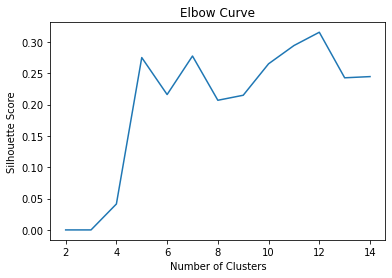

In [30]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [35]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|                text|[0.0,0.0,0.0,0.0,...|         5|
|Pfizer is looking...|[0.04806540875625...|         5|
|Pfizers COVID vac...|[0.50025610368800...|         3|
|pfizers¬†covidvac...|[0.0,0.0,0.0,0.0,...|         5|
|For more informat...|[0.05960954204242...|         9|
|CovidVaccine COVI...|[-0.2550230467739...|         9|
|One of  vaccines ...|[0.04421593534635...|         4|
|NVAX beats BNTX P...|[0.00450288041716...|         5|
|Though Pfizer use...|[-0.0505790027682...|         5|
|Phase III data on...|[0.15676166328007...|         5|
|PfizerBioNTech CO...|[0.06359193763152...|         5|
|So psyched  be pa...|[-0.0040071643692...|         5|
|BioNTech cofounde...|[0.04405919407265...|         5|
|Read  Aug 21 News...|[0.10173814900769...|         5|
|Read Carole Sians...|[0.04725395730151...|         5|
|PfizerBio

In [36]:
predictions.filter("prediction=6").show(50, truncate=False)

+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                        |features                                                                                                                                                                                                    |prediction|
+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Pfizer PFE BioNTec